# Music Analysis/Processing Experimental Notebook

This notebook aims to develop the song analysis and processing that will be used when downloading and analyzing songs and predicting beat maps from new songs.

In [138]:
import librosa
import librosa.display
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
def song_clusters(song_path):
    """This function performs an unsupervised clustering on a given song by computing a chromagram of the song, 
    dividing the song up into similar segments with the librosa.segment.agglomerative() function, then using a
    sklearn AgglomerativeClustering instance to secondarily cluster the similar segments into 7 clusters. Returns a 
    DataFrame with the segment time boundaries and the assigned cluster number. """
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    cluster_init = AgglomerativeClustering()
    bounds = librosa.segment.agglomerative(chromagram, k=1, clusterer = cluster_init)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    chromacluster = AgglomerativeClustering(n_clusters=7, affinity = 'euclidean', linkage = 'ward')
    chromacluster.fit(pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.mean).T))
    clusters = pd.concat([pd.Series(bound_times), pd.Series(chromacluster.labels_)], axis = 1)
    return clusters

In [113]:
def clusters_by_beat(song_path):
    """Similar to song_clusters(), this function clusters beat frames together by their chroma similarity and 
    returns a DataFrame of beat frames with their assigned cluster number."""
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    beat_clusterer = AgglomerativeClustering(n_clusters=None, affinity = 'cosine', linkage='complete', distance_threshold=0.25)
    beat_clusterer.fit(pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.mean).T))
    bclusters = pd.concat([pd.Series(beat_frames), pd.Series(beatcluster.labels_)], axis = 1)
    return bclusters 
    
    

In [161]:
def beat_and_chroma_features(song_path):
    """This function loads a song with the librosa package, computes the chromagram, and isolates the beat times.
    It then combines the beats and chroma features into a single DataFrame, indexed by beat frames. Returns both the
    estimated BPM and chroma feature DataFrame"""
    #Load song and split into harmonic and percussive parts.
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    #Isolate beats and beat times
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    #Compute chromagram & align with beat frames
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    chroma_features = pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.median).T,)
    #Concatenate beat-synced chroma features with beat times (zero added to beginning of beat times to align with beat frames)
    df = pd.concat([pd.DataFrame(np.append(np.zeros(1), beat_times), columns=['beat_times']), chroma_features], axis = 1)
    return tempo, df

In [81]:
def beat(song_path):
    """This function returns a DataFrame with time points with beats identified as 1, nonbeats identified as 0. """
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    song_len = librosa.get_duration(y, sr)
    time = pd.DataFrame(np.arange(0.00, song_len, 0.01), columns = ['_time'])
    ones = np.ones(len(beat_times))
    beat_df = pd.DataFrame({'_time': beat_times, 'beat': ones})
    beat_df['_time'] = round(beat_df['_time'], 2)
    beat_df = pd.merge(beat_df, time, on = '_time', how = 'outer', sort = True)
    beat_df.fillna(0, inplace = True)
    beat_df['beat'] = beat_df['beat'].astype(int)
    return beat_df

In [154]:
def beat_number_and_chroma(song_path):
    """This function reads in a music file and returns a DataFrame of beat numbers (divided into 1/16th beats) and
    chroma features at each beat. Chroma features are calculated for 1/4 beats and propagated forward across the 
    16th beats."""
    #Load music file, estimate beat frames, and compute chromagram
    y, sr = librosa.load(song_path)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr,
                                             trim = False,
                                             units = 'frames')
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                            sr=sr)
    #Make a framework for syncing chroma features to 1/4 beat
    extend = np.array([])
    ind = 0
    while ind < len(beat_frames)-1:
        extend = np.append(extend, np.arange(beat_frames[ind], beat_frames[ind+1], round((beat_frames[ind+1]-beat_frames[ind])/4))[1:4])
        ind += 1
    beat_frames_merged = np.concatenate((np.array([0]), beat_frames, extend))
    beat_frames_merged.sort()
    
    #Sync chroma features to 1/4 beats
    beat_chroma = librosa.util.sync(chromagram,
                                beat_frames_merged.astype(int),
                                aggregate=np.median)
    
    #Add beat count to beat frames
    t = np.arange(0, len(beat_frames), 1)
    beat_numbers = pd.concat([pd.Series(t, name = '_time'), pd.Series(beat_frames, name = 'frame_no')], axis = 1)
    beat_numbers['frame_no'] = beat_numbers['frame_no'].astype(int)
    
    #Merge chroma features with extended beat frames (1/4 beat)
    chromabeats = pd.concat([pd.Series(beat_frames_merged.astype(int), name = 'frame_no'), pd.DataFrame(beat_chroma.T)], axis = 1)
    z = pd.merge(beat_numbers, chromabeats, on = 'frame_no', how = 'outer', sort = True)
    z.interpolate(inplace = True)
    
    #Expand beat frequency to 1/16th beat & merge
    expand_time = pd.DataFrame(np.arange(0.00, z['_time'].max(), 0.0625), columns = ['_time'])
    expanded_chromabeats = pd.merge(z, expand_time, on='_time', how = 'outer', sort = True)
    
    #Forward fill to fill NaNs
    expanded_chromabeats.fillna(method='ffill', inplace = True)
    expanded_chromabeats.drop('frame_no', axis = 1, inplace = True)
    
    return expanded_chromabeats

In [153]:
beat_number_and_chroma('song.egg')

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


,_time,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0000,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
1,0.0625,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
2,0.1250,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
3,0.1875,0.112079,0.149430,0.082660,0.217268,0.454858,0.261024,0.044570,0.057767,0.578666,1.000000,0.510561,0.062225
4,0.2500,0.089512,0.108355,0.058844,0.205773,0.338345,0.173402,0.045705,0.068937,0.648231,1.000000,0.525818,0.083132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10781,673.8125,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10782,673.8750,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10783,673.9375,0.462309,0.318142,0.187176,0.334096,0.734218,0.970816,1.000000,0.741936,0.443432,0.296446,0.294719,0.308568
10784,674.0000,0.726202,0.655926,0.551332,0.460246,0.540458,0.540169,0.619294,0.791518,0.624399,0.477923,0.525815,0.618374


---
**These few lines**

Get chromagram, find length of chromagram frames, convert frames to time, concatenate time with chromagram, upsample to 0.01 seconds, forwardfill NA values

In [27]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

In [83]:
frames = range(len(chromagram[-1]))

In [85]:
t = librosa.frames_to_time(frames)

In [86]:
t

array([0.00000000e+00, 2.32199546e-02, 4.64399093e-02, ...,
       2.73554286e+02, 2.73577506e+02, 2.73600726e+02])

In [97]:
chromatime = pd.concat([pd.Series(t, name = '_time'), pd.DataFrame(chromagram.T)], axis = 1)

In [98]:
chromatime['_time'] = round(chromatime['_time'], 2)

In [99]:
chromatime_upsampled = pd.merge(chromatime, time, on = '_time', how = 'outer', sort = True)

In [100]:
chromatime_upsampled.fillna(method='ffill')

,_time,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00,1.000000,0.861471,0.657415,0.476501,0.464004,0.621972,0.511303,0.884553,0.411557,0.531624,0.897920,0.618933
1,0.01,1.000000,0.861471,0.657415,0.476501,0.464004,0.621972,0.511303,0.884553,0.411557,0.531624,0.897920,0.618933
2,0.02,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
3,0.03,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
4,0.04,0.604023,0.549450,0.623541,0.517033,0.347416,0.393778,0.523475,0.454867,0.515675,1.000000,0.645002,0.394877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28968,273.56,0.485726,0.975796,0.939277,1.000000,0.853505,0.585761,0.511810,0.470680,0.398962,0.285975,0.173652,0.098679
28969,273.57,0.485726,0.975796,0.939277,1.000000,0.853505,0.585761,0.511810,0.470680,0.398962,0.285975,0.173652,0.098679
28970,273.58,0.387917,1.000000,0.665680,0.739635,0.659383,0.327451,0.429546,0.304075,0.200063,0.162344,0.098706,0.082790
28971,273.59,0.387917,1.000000,0.665680,0.739635,0.659383,0.327451,0.429546,0.304075,0.200063,0.162344,0.098706,0.082790


---

In [49]:
song_len = librosa.get_duration(y, sr)

--- 
These next cells explore using clustering, but likely aren't worth using. The two clustering functions at the top of the notebook are based on these.

In [7]:
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

In [18]:
cluster = AgglomerativeClustering()

In [24]:
bounds = librosa.segment.agglomerative(chromagram, k=1, clusterer = cluster)

In [25]:
bound_times = librosa.frames_to_time(bounds, sr=sr)

In [53]:
pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.median).T)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.538253,0.386730,0.313347,0.518682,0.394170,0.227893,0.433448,0.542439,0.652211,0.318581,1.000000,0.249358
1,0.777480,0.755178,0.760264,0.806661,0.709981,0.656099,0.741775,0.800198,0.802934,0.807873,0.678092,0.642478
2,0.579375,0.547471,0.612376,0.603734,0.513145,0.295989,0.201167,0.349394,0.555471,0.664634,0.954781,0.796395
3,0.178627,0.643371,1.000000,0.532685,0.062216,0.204454,0.474195,0.306502,0.128377,0.246439,0.333455,0.262831
4,0.595438,0.378639,0.319277,0.188062,0.081779,0.363122,0.705372,0.473456,0.277666,0.378223,0.707941,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
881,0.246090,1.000000,0.934379,0.228646,0.047020,0.030136,0.025039,0.042440,0.130570,0.116196,0.051525,0.070140
882,1.000000,0.699271,0.206373,0.053424,0.043551,0.039793,0.053311,0.070246,0.063478,0.058047,0.108288,0.492885
883,0.244710,0.795720,1.000000,0.413829,0.135172,0.047179,0.033197,0.034497,0.073223,0.088647,0.072052,0.127829
884,0.565167,0.152349,0.097581,0.083755,0.078830,0.084488,0.098158,0.104388,0.127989,0.198898,0.639250,1.000000


In [89]:
chromacluster = AgglomerativeClustering(n_clusters=7, affinity = 'euclidean', linkage = 'ward')
chromacluster.fit(pd.DataFrame(librosa.util.sync(chromagram, bounds, aggregate=np.mean).T))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=7)

In [94]:
beatcluster = AgglomerativeClustering(n_clusters=None, affinity = 'cosine', linkage='complete', distance_threshold=0.25)
beatcluster.fit(pd.DataFrame(librosa.util.sync(chromagram, beat_frames, aggregate=np.mean).T))

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
                        connectivity=None, distance_threshold=0.25,
                        linkage='complete', memory=None, n_clusters=None)

In [99]:
bclusters = pd.concat([pd.Series(beat_times), pd.Series(beatcluster.labels_)], axis = 1)

In [90]:
clusters = pd.concat([pd.Series(bound_times), pd.Series(chromacluster.labels_), pd.Series()], axis = 1)

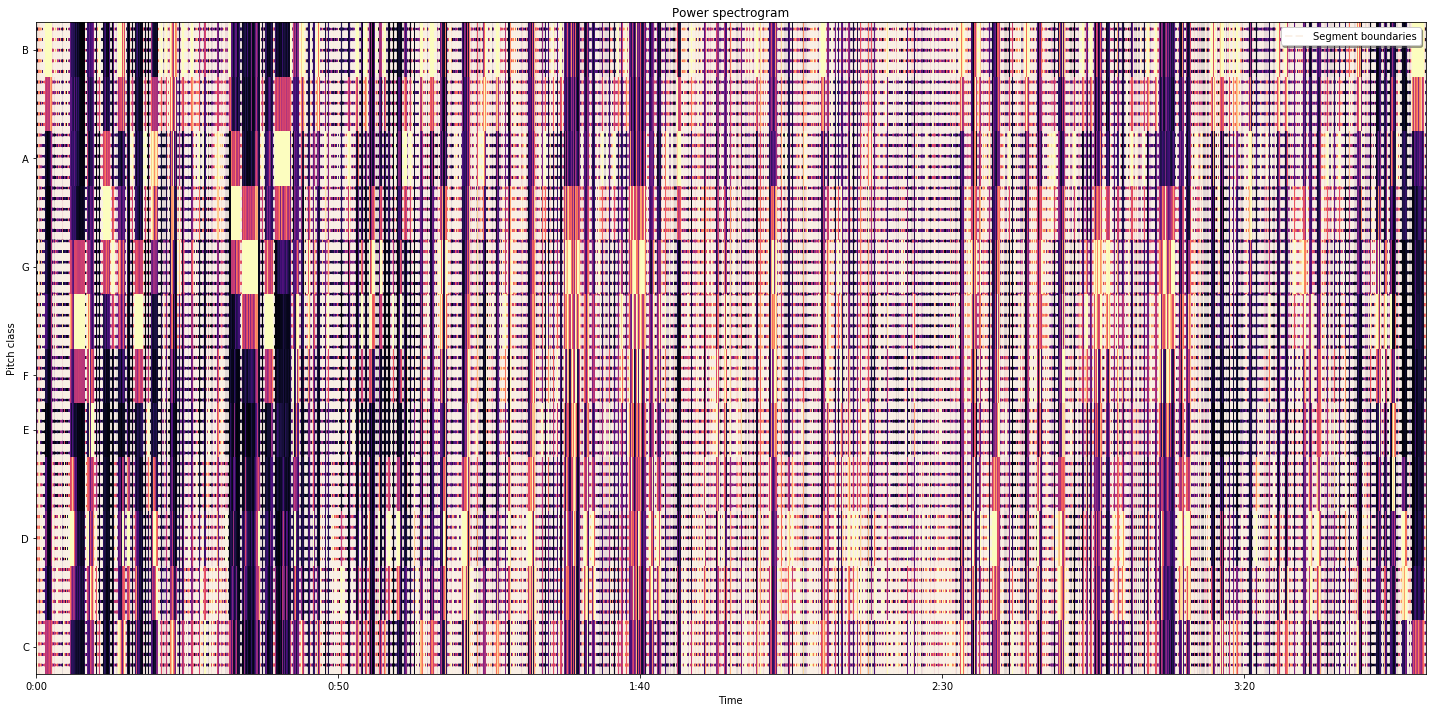

In [27]:
plt.figure(figsize=(20, 10))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.vlines(bound_times, 0, chromagram.shape[0], color='linen', linestyle='--', linewidth=2, alpha=0.9, label='Segment boundaries')
plt.axis('tight')
plt.legend(frameon=True, shadow=True)
plt.title('Power spectrogram')
plt.tight_layout()
plt.show()

In [119]:
# Use time-delay embedding to reduce noise
chroma_stack = librosa.feature.stack_memory(chromagram, n_steps=3)
# Build recurrence, suppress self-loops within 1 second
rec = librosa.segment.recurrence_matrix(chroma_stack, width=43,
                                        mode='affinity',
                                        metric='cosine')
# using infinite cost for gaps enforces strict path continuation
L_score, L_path = librosa.sequence.rqa(rec, np.inf, np.inf,
                                       knight_moves=True, backtrack=True)

---
## Use pychorus to identify verse/chorus structure in song

In [10]:
import sys

sys.path.append("../pychorus/")

import pychorus.helpers as pc
import pychorus.similarity_matrix as sm

In [21]:
chroma, y, sr, song_length_sec = pc.create_chroma("./2144 (Shut Up and Dance - bennydabeast)/song.ogg")

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [72]:
chorus_list = pc.find_chorus(chroma, sr, song_length_sec, 10) #Line (start, end, lag)

In [73]:
chorus_list

[(Line (897 954 848), 6, 57),
 (Line (513 569 464), 4, 56),
 (Line (896 964 81), 3, 68),
 (Line (813 869 525), 3, 56),
 (Line (863 957 606), 2, 94),
 (Line (864 958 384), 1, 94),
 (Line (381 576 222), 0, 195),
 (Line (284 362 242), 0, 78),
 (Line (787 864 767), 0, 77)]

In [74]:
times = []
for x in chorus_list:
    start = (x[0].start / chroma_sr)
    end = (x[0].end / chroma_sr)
    times.append((start, end))

In [75]:
times.sort(key = lambda x: x[0])

In [76]:
times

[(52.71861629579099, 67.19767288407161),
 (70.72462256583228, 106.92226403653383),
 (95.22764140753794, 105.62286152220095),
 (146.0899683971391, 160.38339605480076),
 (150.91632059323265, 161.31154070789566),
 (160.19776712418178, 177.6468866023661),
 (160.38339605480076, 177.8325155329851),
 (166.3235218346082, 178.94628911669898),
 (166.50915076522716, 177.08999981050917)]

- Might want to use these times as a start for identifying song segments. Some overlap obviously, so maybe figure out a way to determine which parts overlap and combine into one segment.

In [ ]:
"Line ({} {} {})".format(self.start, self.end, self.lag)

In [24]:
time_time_similarity = sm.TimeTimeSimilarityMatrix(chroma, sr)

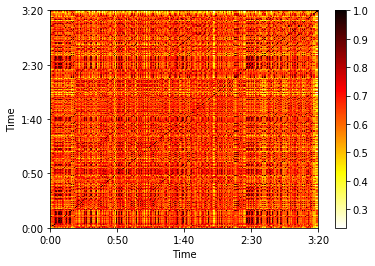

In [25]:
time_time_similarity.display()

In [77]:
time_lag_similarity = sm.TimeLagSimilarityMatrix(chroma, sr)

In [78]:
chroma_sr = chroma.shape[1] / song_length_sec
smoothing_size_samples = int(2.5 * chroma_sr)
time_lag_similarity.denoise(time_time_similarity.matrix,
                                smoothing_size_samples)

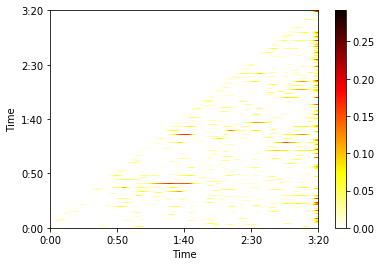

In [79]:
time_lag_similarity.display()

---
## Laplacian Segmentation 

In [139]:
from __future__ import print_function

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sklearn.cluster

import librosa
import librosa.display

In [141]:
y, sr = librosa.load('song.egg')

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


TypeError: savefig() missing 1 required positional argument: 'fname'

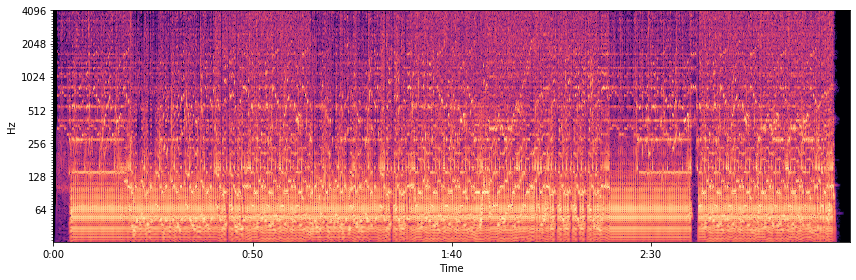

In [142]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                            ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
plt.tight_layout()


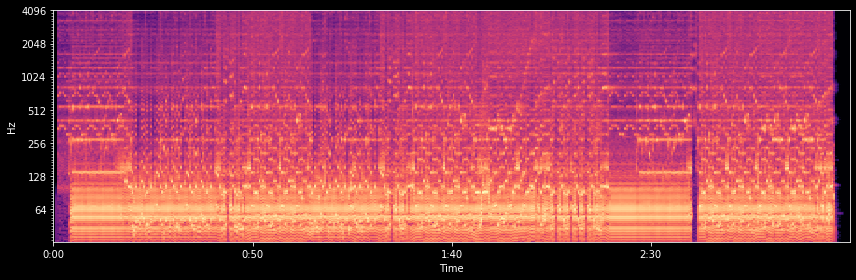

In [153]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0,
                                                            x_max=C.shape[1]),
                                    sr=sr)

plt.style.use('dark_background')
plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times)
plt.tight_layout()
plt.savefig('spectrogram.png', dpi = 300, transparent = True)

In [144]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                      sym=True)

# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 7))

In [145]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [146]:
deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

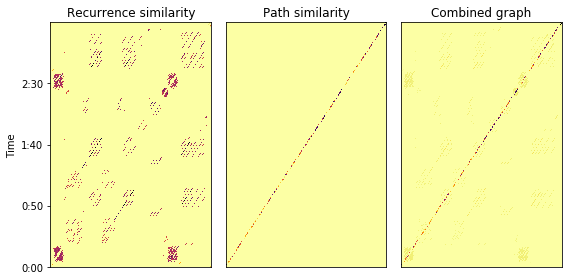

In [147]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         y_coords=beat_times)
plt.title('Recurrence similarity')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path similarity')
plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Combined graph')
plt.tight_layout()

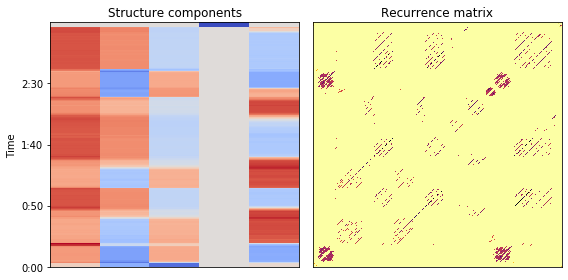

In [148]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)


# and its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)


# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k-1:k]


# Plot the resulting representation (Figure 1, center and right)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')

plt.subplot(1, 2, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.tight_layout()

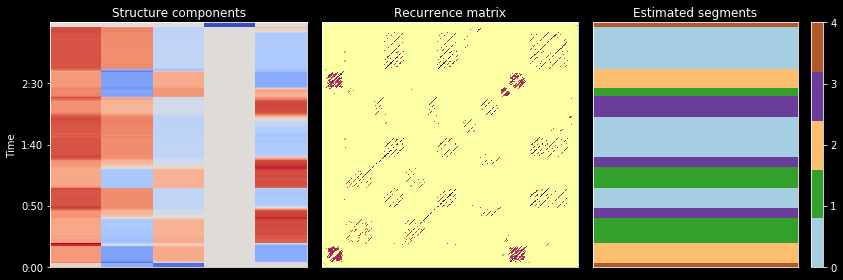

In [154]:
KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)


# and plot the results
plt.style.use('dark_background')
plt.figure(figsize=(12, 4))
colors = plt.get_cmap('Paired', k)

plt.subplot(1, 3, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')
plt.subplot(1, 3, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         y_coords=beat_times)
plt.title('Structure components')
plt.subplot(1, 3, 3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=colors)
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))
plt.tight_layout()
plt.savefig('recurrence_and_segments.png', dpi = 300, transparent = True)

In [151]:
bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])

# Count beat 0 as a boundary
bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)

# Compute the segment label for each boundary
bound_segs = list(seg_ids[bound_beats])

# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Make sure we cover to the end of the track
bound_frames = librosa.util.fix_frames(bound_frames,
                                       x_min=None,
                                       x_max=C.shape[1]-1)

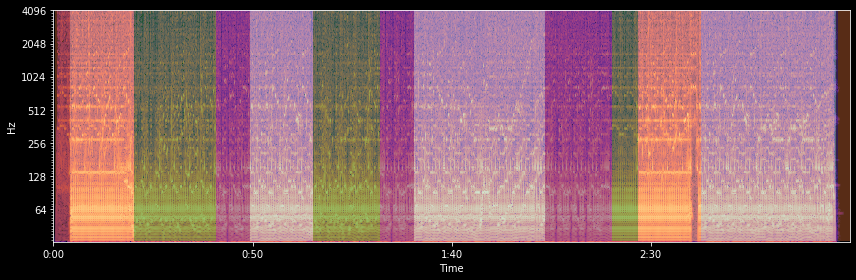

In [155]:
import matplotlib.patches as patches
plt.style.use('dark_background')
plt.figure(figsize=(12, 4))

bound_times = librosa.frames_to_time(bound_frames)
freqs = librosa.cqt_frequencies(n_bins=C.shape[0],
                                fmin=librosa.note_to_hz('C1'),
                                bins_per_octave=BINS_PER_OCTAVE)

librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
ax = plt.gca()

for interval, label in zip(zip(bound_times, bound_times[1:]), bound_segs):
    ax.add_patch(patches.Rectangle((interval[0], freqs[0]),
                                   interval[1] - interval[0],
                                   freqs[-1],
                                   facecolor=colors(label),
                                   alpha=0.50))

plt.tight_layout()
plt.savefig('segmented_spectrogram.png', dpi = 300, transparent = True)
plt.show()

In [32]:
def laplacian_segmentation(y, sr, k = 5):
    """This function uses the Laplacian Segmentation method described in McFee and Ellis, 2014, and adapted from
    expample code in the librosa documentation. It returns the segment boundaries (in frame number and time) and 
    segment ID's of isolated music file segments."""
    BINS_PER_OCTAVE = 12 * 3
    N_OCTAVES = 7
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                                        ref=np.max)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    Csync = librosa.util.sync(C, beats, aggregate=np.median)

    # For plotting purposes, we'll need the timing of the beats
    # we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
    beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                                x_min=0,
                                                                x_max=C.shape[1]),
                                                                sr=sr)
    
    R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity',
                                          sym=True)
    # Enhance diagonals with a median filter (Equation 2)
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)

    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)

    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)

    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

    A = mu * Rf + (1 - mu) * R_path
    
    L = scipy.sparse.csgraph.laplacian(A, normed=True)


    # and its spectral decomposition
    evals, evecs = scipy.linalg.eigh(L)


    # We can clean this up further with a median filter.
    # This can help smooth over small discontinuities
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


    # cumulative normalization is needed for symmetric normalize laplacian eigenvectors
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5

    # If we want k clusters, use the first k normalized eigenvectors.
    # Fun exercise: see how the segmentation changes as you vary k

    k = k

    X = evecs[:, :k] / Cnorm[:, k-1:k]
    
    KM = sklearn.cluster.KMeans(n_clusters=k)

    seg_ids = KM.fit_predict(X)
    
    bound_beats = 1 + np.flatnonzero(seg_ids[:-1] != seg_ids[1:])

    # Count beat 0 as a boundary
    bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)

    # Compute the segment label for each boundary
    bound_segs = list(seg_ids[bound_beats])

    # Convert beat indices to frames
    bound_frames = beats[bound_beats]

    # Make sure we cover to the end of the track
#     bound_frames = librosa.util.fix_frames(bound_frames,
#                                            x_min=None,
#                                            x_max=C.shape[1]-1)
#     bound_times = librosa.frames_to_time(bound_frames)
#     segments = list(zip(zip(bound_frames, bound_frames[1:]), zip(bound_times, bound_times[1:]), bound_segs))
    segments = list(zip(zip(bound_beats, bound_beats[1:]), bound_segs))
    
    return segments #beats, bound_beats, bound_segs #pd.DataFrame(segments, columns = ['frame_bounds', 'time_bounds', 'segment_id'])

In [33]:
segments = laplacian_segmentation(y, sr)

In [34]:
segments

[((0, 8), 4),
 ((8, 42), 2),
 ((42, 86), 3),
 ((86, 104), 0),
 ((104, 138), 1),
 ((138, 174), 3),
 ((174, 192), 0),
 ((192, 262), 1),
 ((262, 298), 0),
 ((298, 312), 3),
 ((312, 346), 2),
 ((346, 418), 1),
 ((418, 419), 0)]

In [37]:
lengths = []
for seg in segments:
    length = seg[0][1] - seg[0][0]
    lengths.append(length)

In [59]:
df = pd.concat([pd.Series(lengths, name = 'length'), pd.Series([x[1] for x in segments], name = 'seg_no')], axis = 1)

In [61]:
df

,length,seg_no
0,8,4
1,34,2
2,44,3
3,18,0
4,34,1
5,36,3
6,18,0
7,70,1
8,36,0
9,14,3


for each row:
1. Check if segment type has been predicted before
    a. if not, predict new sequence of beat length using last state from previous segment (if not first segment) as initial state for prediction
    b. if so, repeat previous sequence by
        i. checking length - if too long, truncate, if too short, extend by using last state as initial state for prediction. 
    c. continue until all segments have been predicted
        

In [78]:
def segment_predictions(segment_df, HMM_model):
    """This function predicts a Markov chain walk for each segment of a segmented music file. It will repeat a 
    walk for segments that it has already mapped previously (truncating or extending as necessary)."""
    
    #make predictions
    preds = pd.DataFrame([])
    
    completed_segments = {}
    
    for index, row in segment_df.iterrows():
        if row['seg_no'] not in completed_segments.keys():
            if index == 0:
                pred = HMM_model.walk()
                while len(pred) < row['length']:
                    pred = HMM_model.walk()
                completed_segments.update({row['seg_no']: {'start':0, 'end': len(pred)}})
                preds = pd.concat([preds, pred[0: row['length']]], axis = 0, ignore_index = True)
                
            else:
                pred = HMM_model.walk(init_state = preds.iloc[-1, 0])
                while len(pred) < row['length']:
                    pred = HMM_model.walk(init_state = preds.iloc[-1, 0])
                completed_segments.update({row['seg_no']: {'start': len(preds)+1, 'end': len(preds)+len(pred)}})
                preds = pd.concat([preds, pred[0: row['length']]], axis = 0, ignore_index = True)

        else:
            if row['length'] <= (completed_segments[row['seg_no']]['end'] - completed_segments[row['seg_no']]['start']): #segment_df[segment_df['seg_no'] == row['seg_no']].iloc[0, 0]:
                pred = preds.iloc[completed_segments[row['seg_no']]['start']: completed_segments[row['seg_no']]['start'] + row['length'], 0]
                preds = pd.concat([preds, pred], axis = 0, ignore_index = True)
            else:
                extend = HMM_model.walk(init_state = preds.iloc[completed_segments[row['seg_no']]['end'], 0])
                pred = preds.iloc[completed_segments[row['seg_no']]['start']: completed_segments[row['seg_no']]['end'], 0]
                diff = row['length'] - len(pred)
                pred = pd.concat([pred, extend[0: diff+1]], axis = 0, ignore_index = True)
                completed_segments.update({row['seg_no']: {'start': len(preds)+1, 'end': len(preds)+len(pred)}})
                preds = pd.concat([preds, pred], axis = 0, ignore_index = True)
    return preds
            

In [79]:
completed_segments, preds = segment_predictions(df, None)

In [80]:
completed_segments

{4: {'start': 0, 'end': 8},
 2: {'start': 316, 'end': 350},
 3: {'start': 43, 'end': 86},
 0: {'start': 265, 'end': 301},
 1: {'start': 351, 'end': 423}}

In [81]:
preds

,0
0,3.0
1,4.0
2,5.0
3,8.0
4,6.0
...,...
419,4.0
420,8.0
421,8.0
422,6.0


In [60]:
df.groupby('seg_no').max()

,length
seg_no,
0,36
1,72
2,34
3,44
4,8


In [23]:
list(range(len(beats)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [20]:
bound_beats

array([  0,   8,  42,  86, 104, 138, 174, 192, 262, 298, 312, 346, 418,
       419])

In [16]:
bound_segs

[1, 2, 0, 4, 3, 0, 4, 3, 4, 0, 2, 3, 4, 1]

In [28]:
seg_set = set(bound_segs)

for x in seg_set:
    calculate longest interval for each x
    make a prediction for longest interval length of each x
    repeat prediction for shorter intervals of x
    

In [51]:
pd.DataFrame(segments, columns = ['frame_bounds', 'time_bounds', 'segment_id'])

,frame_bounds,time_bounds,segment_id
0,"(22, 184)","(0.5108390022675737, 4.272471655328798)",4
1,"(184, 870)","(4.272471655328798, 20.201360544217685)",2
2,"(870, 1758)","(20.201360544217685, 40.820680272108845)",3
3,"(1758, 2121)","(40.820680272108845, 49.24952380952381)",1
4,"(2121, 2808)","(49.24952380952381, 65.20163265306122)",0
5,"(2808, 3535)","(65.20163265306122, 82.08253968253969)",3
6,"(3535, 3898)","(82.08253968253969, 90.51138321995465)",1
7,"(3898, 5311)","(90.51138321995465, 123.321179138322)",0
8,"(5311, 6038)","(123.321179138322, 140.20208616780045)",1
9,"(6038, 6320)","(140.20208616780045, 146.7501133786848)",3


In [82]:
def segments_to_df(segments):
    """Helper function to translate a song semgmenation to a pandas DataFrame."""
    lengths = []
    for seg in segments:
        length = seg[0][1] - seg[0][0]
        lengths.append(length)
    df = pd.concat([pd.Series(lengths, name = 'length'), pd.Series([x[1] for x in segments], name = 'seg_no')], axis = 1)
    return df

---
## Attempt to find average amplitude throughout song?

In [119]:
y, sr = librosa.load('song.egg')

/opt/anaconda3/envs/BSmapsynth-env/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [137]:
def amplitude_rate_modulation(y, sr, difficulty):
    """This function uses the average amplitude (i.e., 'loudness') of a beat and the difficulty level to determine 
    how many blocks will be placed within the beat. Returns a list of beat numbers."""
    #Make amplitude matrix
    D = np.abs(librosa.stft(y))
    db = librosa.amplitude_to_db(D, ref=np.max)
    #Get beat frames and sync with amplitudes
    tempo, beat_frames = librosa.beat.beat_track(y, sr, trim = False)
    beat_db = pd.DataFrame(librosa.util.sync(db, beat_frames, aggregate = np.mean))
    #Mean amplitude per beat
    avg_beat_db = beat_db.mean()
    #Choose rates and smooth rate transitions
    rates = [0]
    counter = 1
    while counter < len(avg_beat_db)-1:
        rate = choose_rate(np.mean([avg_beat_db.iloc[counter-1], avg_beat_db.iloc[counter], avg_beat_db.iloc[counter+1]]), difficulty)
        diff = rate - rates[-1]
        while diff > 2 or diff < -4:
            rate = choose_rate(np.mean([avg_beat_db.iloc[counter-1], avg_beat_db.iloc[counter], avg_beat_db.iloc[counter+1]]), difficulty)
            diff = rates[-1] - rate
        rates.append(rate)
        counter +=1
    #Make list of beat numbers based on rates
    beat_num_list = []
    for ind, val in enumerate(rates):
        if val == 0:
            continue
        else:
            num_list = [ind, ind+1]
            #fraction = 1/val
            for x in range(val):
                num_list.append(ind+(x/val))
            for y in num_list:
                beat_num_list.append(y)
    beat_num_list = list(set(beat_num_list))
    beat_num_list.sort()
    
    return beat_num_list

In [ ]:
def segments_to_df_rate_modulated(segments, modulated_beat_list):
    
    lengths = []
    for seg in segments:
        length = seg[0][1] - seg[0][0]
        if length != len(modulated_beat_list[seg[0][0]:seg[0][1]]):
            length = len(modulated_beat_list[seg[0][0]:seg[0][1]])
        lengths.append(length)
    df = pd.concat([pd.Series(lengths, name = 'length'), pd.Series([x[1] for x in segments], name = 'seg_no')], axis = 1)
    return df

In [131]:
def choose_rate(db, difficulty):
    """This function modulates the block placement rate by using the average loudness across beats to choose
    how many blocks per beat will be placed. Takes in the difficulty level and the amplitude and returns an 
    integer in the set {0, 2, 4, 8, 16}."""
    db = np.abs(db)
    p = None
    if difficulty.casefold() == 'easy'.casefold():
        if db > 70:
            p = [0.7, 0.27, 0.02, 0.01, 0]
        elif db <= 70 and db > 55:
            p = [0.6, 0.35, 0.03, 0.02, 0]
        elif db <= 55 and db > 50:
            p = [0.4, 0.55, 0.03, 0.02, 0]
        elif db <= 50 and db > 45:
            p = [0.1, 0.7, 0.15, 0.05, 0]
        else:
            p = [0.1, 0.5, 0.3, 0.1, 0]
    elif difficulty.casefold() == 'normal'.casefold():
        if db > 70:
            p = [0.7, 0.25, 0.03, 0.02, 0]
        elif db <= 70 and db > 55:
            p = [0.5, 0.4, 0.07, 0.03, 0]
        elif db <= 55 and db > 50:
            p = [0.25, 0.6, 0.10, 0.05, 0]
        elif db <= 50 and db > 45:
            p = [0.05, 0.6, 0.25, 0.10, 0]
        else:
            p = [0.01, 0.2, 0.6, 0.15, 0.04]
    elif difficulty.casefold() == 'hard'.casefold():
        if db > 70:
            p = [0.7, 0.25, 0.03, 0.02, 0]
        elif db <= 70 and db > 55:
            p = [0.4, 0.5, 0.07, 0.03, 0]
        elif db <= 55 and db > 50:
            p = [0.2, 0.6, 0.15, 0.05, 0]
        elif db <= 50 and db > 45:
            p = [0.05, 0.3, 0.5, 0.15, 0]
        else:
            p = [0.01, 0.1, 0.6, 0.25, 0.04]
    elif difficulty.casefold() == 'expert'.casefold():
        if db > 70:
            p = [0.5, 0.45, 0.03, 0.02, 0]
        elif db <= 70 and db > 55:
            p = [0.2, 0.7, 0.07, 0.03, 0]
        elif db <= 55 and db > 50:
            p = [0.05, 0.4, 0.5, 0.05, 0]
        elif db <= 50 and db > 45:
            p = [0.01, 0.05, 0.7, 0.15, 0.09]
        else:
            p = [0, 0.1, 0.2, 0.3, 0.4]
    elif difficulty.casefold() == 'expertPlus'.casefold():
        if db > 70:
            p = [0.5, 0.45, 0.03, 0.02, 0]
        elif db <= 70 and db > 55:
            p = [0.1, 0.6, 0.27, 0.03, 0]
        elif db <= 55 and db > 50:
            p = [0, 0.05, 0.8, 0.1, 0.05]
        elif db <= 50 and db > 45:
            p = [0, 0.05, 0.05, 0.7, 0.2]
        else:
            p = [0, 0, 0.1, 0.2, 0.7]
    return np.random.choice([0, 2, 4, 8, 16], p = p)
    

In [134]:
amplitude_rate_modulation(y, sr, 'expertPlus')

[1,
 1.5,
 2,
 3,
 3.5,
 4,
 8,
 8.5,
 9,
 9.5,
 10,
 10.5,
 11,
 11.5,
 12,
 12.5,
 13,
 13.25,
 13.5,
 13.75,
 14,
 15,
 15.5,
 16,
 19,
 19.5,
 20,
 21,
 21.5,
 22,
 23,
 23.5,
 24,
 25,
 25.5,
 26,
 26.5,
 27,
 29,
 29.5,
 30,
 30.5,
 31,
 31.5,
 32,
 32.25,
 32.5,
 32.75,
 33,
 33.5,
 34,
 35,
 35.5,
 36,
 36.25,
 36.5,
 36.75,
 37,
 37.5,
 38,
 40,
 40.5,
 41,
 41.5,
 42,
 44,
 44.5,
 45,
 52,
 52.5,
 53,
 53.5,
 54,
 54.5,
 55,
 56,
 56.5,
 57,
 57.5,
 58,
 58.5,
 59,
 59.5,
 60,
 62,
 62.5,
 63,
 63.5,
 64,
 64.5,
 65,
 65.25,
 65.5,
 65.75,
 66,
 66.125,
 66.25,
 66.375,
 66.5,
 66.625,
 66.75,
 66.875,
 67,
 67.125,
 67.25,
 67.375,
 67.5,
 67.625,
 67.75,
 67.875,
 68,
 68.125,
 68.25,
 68.375,
 68.5,
 68.625,
 68.75,
 68.875,
 69,
 69.125,
 69.25,
 69.375,
 69.5,
 69.625,
 69.75,
 69.875,
 70,
 70.125,
 70.25,
 70.375,
 70.5,
 70.625,
 70.75,
 70.875,
 71,
 71.125,
 71.25,
 71.375,
 71.5,
 71.625,
 71.75,
 71.875,
 72,
 72.125,
 72.25,
 72.375,
 72.5,
 72.625,
 72.75,
 72.8

In [5]:
D = np.abs(librosa.stft(y))

In [22]:
db = librosa.amplitude_to_db(D, ref=np.max)

In [28]:
tempo, beat_frames = librosa.beat.beat_track(y, sr, trim = False)

In [29]:
beat_frames

array([  22,   42,   63,   83,  104,  124,  144,  164,  184,  204,  224,
        244,  264,  285,  305,  325,  345,  365,  386,  406,  426,  446,
        466,  486,  507,  527,  547,  567,  588,  608,  628,  648,  668,
        688,  708,  729,  749,  769,  789,  810,  830,  850,  870,  890,
        910,  930,  950,  971,  991, 1011, 1031, 1051, 1072, 1092, 1112,
       1132, 1153, 1173, 1193, 1213, 1233, 1254, 1274, 1293, 1314, 1334,
       1354, 1374, 1395, 1415, 1435, 1456, 1476, 1496, 1516, 1536, 1557,
       1577, 1597, 1617, 1637, 1657, 1677, 1697, 1718, 1738, 1758, 1778,
       1799, 1819, 1839, 1859, 1879, 1900, 1920, 1940, 1960, 1980, 2000,
       2021, 2041, 2061, 2081, 2101, 2121, 2142, 2162, 2182, 2202, 2223,
       2243, 2263, 2283, 2303, 2324, 2344, 2364, 2384, 2404, 2424, 2445,
       2465, 2485, 2505, 2525, 2546, 2566, 2586, 2606, 2627, 2647, 2667,
       2687, 2707, 2727, 2748, 2768, 2788, 2808, 2828, 2848, 2868, 2889,
       2909, 2929, 2949, 2970, 2990, 3010, 3030, 30

In [61]:
beat_db = pd.DataFrame(librosa.util.sync(db, beat_frames, aggregate = np.mean))

In [63]:
avg_beat_db = beat_db.mean()

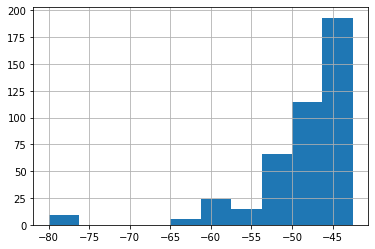

In [124]:
avg_beat_db.hist()

In [115]:
rates = [0]
counter = 1
while counter < len(avg_beat_db)-1:
    rate = choose_rate(np.mean([avg_beat_db.iloc[counter-1], avg_beat_db.iloc[counter], avg_beat_db.iloc[counter+1]]), 'easy')
    diff = rates[-1] - rate
    while diff > 2 or diff < -2:
        rate = choose_rate(np.mean([avg_beat_db.iloc[counter-1], avg_beat_db.iloc[counter], avg_beat_db.iloc[counter+1]]), 'easy')
        diff = rates[-1] - rate
    rates.append(rate)
    counter +=1

In [116]:
beat_num_list = []
for ind, val in enumerate(rates):
    if val == 0:
        continue
    else:
        num_list = [ind, ind+1]
        #fraction = 1/val
        for x in range(val):
            num_list.append(ind+(x/val))
        for y in num_list:
            beat_num_list.append(y)
unique = list(set(beat_num_list))
unique.sort()

In [117]:
unique

[1,
 1.5,
 2,
 7,
 7.5,
 8,
 9,
 9.5,
 10,
 10.5,
 11,
 14,
 14.5,
 15,
 15.5,
 16,
 17,
 17.5,
 18,
 18.5,
 19,
 21,
 21.5,
 22,
 22.5,
 23,
 23.5,
 24,
 24.5,
 25,
 26,
 26.5,
 27,
 28,
 28.5,
 29,
 31,
 31.5,
 32,
 32.5,
 33,
 33.5,
 34,
 34.5,
 35,
 35.5,
 36,
 37,
 37.5,
 38,
 38.5,
 39,
 39.25,
 39.5,
 39.75,
 40,
 40.5,
 41,
 42,
 42.5,
 43,
 45,
 45.5,
 46,
 46.5,
 47,
 47.5,
 48,
 48.25,
 48.5,
 48.75,
 49,
 49.5,
 50,
 52,
 52.5,
 53,
 53.5,
 54,
 56,
 56.5,
 57,
 57.5,
 58,
 62,
 62.5,
 63,
 63.5,
 64,
 64.5,
 65,
 65.5,
 66,
 66.5,
 67,
 67.5,
 68,
 71,
 71.5,
 72,
 72.5,
 73,
 73.5,
 74,
 78,
 78.5,
 79,
 79.5,
 80,
 80.5,
 81,
 81.5,
 82,
 82.5,
 83,
 83.5,
 84,
 84.5,
 85,
 85.5,
 86,
 87,
 87.5,
 88,
 90,
 90.5,
 91,
 92,
 92.5,
 93,
 93.5,
 94,
 94.5,
 95,
 95.5,
 96,
 96.5,
 97,
 97.5,
 98,
 98.25,
 98.5,
 98.75,
 99,
 99.5,
 100,
 101,
 101.5,
 102,
 102.5,
 103,
 103.5,
 104,
 109,
 109.5,
 110,
 110.5,
 111,
 111.5,
 112,
 113,
 113.5,
 114,
 114.5,
 115,
 115.5,
 

In [92]:
rates

[0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 4,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 4,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 4,
 2,
 2,
 2,


In [84]:
pd.concat([pd.Series(rates, name = 'rate'), pd.Series(list(range(len(avg_beat_db))[1:]), name = 'beat_no')], axis = 1)

,rate,beat_no
0,0,1
1,2,2
2,0,3
3,0,4
4,0,5
...,...,...
420,2,421
421,0,422
422,0,423
423,2,424


In [59]:
choose_rate(20, 'expert')

8